# Lab notebook

## Overview
This notebook records basic analysis of the project aiming at compare the performances of HyAsP and MOB-recon on tw data sets of *E faecalis* and *E facium* samples.

In [1]:
# Python packages.
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

import journal_utils

## E faecalis data, 2022-10-02

The *E faecalis* data set is available at [2022-10-02_E_faecalis](../data/2022-10-02_E_faecalis/README.md).

The summary files are the [list of samples](../data/2022-10-02_E_faecalis/E_faecalis_samples.txt) and the [labeling of contigs](../data/2022-10-02_E_faecalis/E_faecalis_labels.csv).

In [2]:
# Data set summary files
E_faecalis_samples_file = '../data/2022-10-02_E_faecalis/E_faecalis_samples.txt'
E_faecalis_labels_file = '../data/2022-10-02_E_faecalis/E_faecalis_labels.csv'

E_faecalis_samples_list = journal_utils.samples_file2list(E_faecalis_samples_file)
E_faecalis_labels_df = pd.read_csv(E_faecalis_labels_file)

In [3]:
# Statsitics on samples
E_faecalis_nb_samples_from_list = len(E_faecalis_samples_list)
E_faecalis_samples_from_labels = list(E_faecalis_labels_df['SRA'].unique())
E_faecalis_nb_samples_from_labels = len(E_faecalis_samples_from_labels)
E_faecalis_samples_diff_list = journal_utils.diff_lists(E_faecalis_samples_list, E_faecalis_samples_from_labels)
E_faecalis_samples_diff_labels = journal_utils.diff_lists(E_faecalis_samples_from_labels, E_faecalis_samples_list)

print(f'There are {E_faecalis_nb_samples_from_list} E.faecalis samples and {E_faecalis_nb_samples_from_labels} samples from the labels file')
print(f'Samples from list but not from labels: {",".join(E_faecalis_samples_diff_list)}')
print(f'Samples from labels but not from list: {",".join(E_faecalis_samples_diff_labels)}')

There are 56 E.faecalis samples and 60 samples from the labels file
Samples from list but not from labels: 
Samples from labels but not from list: SRR13726590,SRR13725727,SRR13726582,SRR14024961


**WARNING.**
There is an issue with the provided data as there are 4 samples that are provided with labels but are not in the list of samples for which data is available.

We discard the contigs from the corresponding samples in the database of contig labels.

In [26]:
# Discarding from the labeld dataframe rows from samples is not in the list of samples
E_faecalis_labels_df = E_faecalis_labels_df[~E_faecalis_labels_df['SRA'].isin(E_faecalis_samples_diff_labels)]
# Plasmid and chromosome contigs
E_faecalis_labels_df_plasmid = E_faecalis_labels_df.loc[E_faecalis_labels_df['classification']=='plasmid']
E_faecalis_labels_df_chromosome = E_faecalis_labels_df.loc[E_faecalis_labels_df['classification']=='chromosome']

In [36]:
# Statistics on contigs
E_faecalis_nb_contigs = len(E_faecalis_labels_df.index)
E_faecalis_nb_plasmid_contigs = len(E_faecalis_labels_df_plasmid.index)
E_faecalis_nb_chromosome_contigs = len(E_faecalis_labels_df_chromosome.index)

print(f'There are {E_faecalis_nb_contigs} hybrid contigs with a label.')
print(f'There are {E_faecalis_nb_plasmid_contigs} plasmid hybrid contigs.')
print(f'There are {E_faecalis_nb_chromosome_contigs} plasmid hybrid contigs.')

if E_faecalis_nb_contigs != E_faecalis_nb_plasmid_contigs+E_faecalis_nb_chromosome_contigs:
    print('WARNING: some hybrid contigs are unlabeled')

There are 751 hybrid contigs with a label.
There are 67 plasmid hybrid contigs.
There are 684 plasmid hybrid contigs.


**Comments.**
This was a preliminary and very rough analysis of the data.
We could do more preliminary analysis, such as the length distribution of hybrid contigs for each class (plasmid or chromosome), see below.

Text(0.5, 0.98, 'Contigs length distribution by label')

<Figure size 640x480 with 0 Axes>

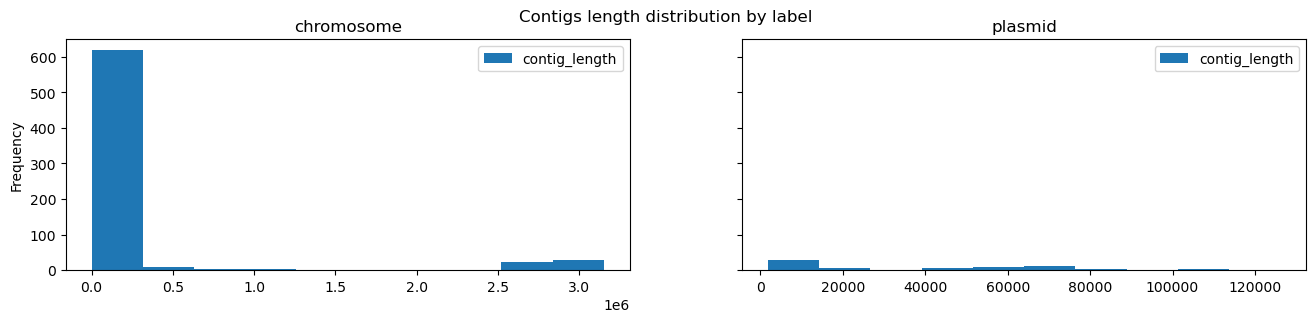

In [25]:
plt.figure()
ax = E_faecalis_labels_df.plot.hist(column=['contig_length'], by='classification', figsize=(16, 3), layout=(1,2), sharey=True)
plt.suptitle('Contigs length distribution by label')

As expected the plasmid contigs do not contain very large contigs.
We can however notice an apparently large number of hybrid contigs labeled as chromosomes and of short length, which might be a problem.

In [35]:
# Number of short chromosome contigs defined as chromosome contigs of length below the median length of plasmid contigs
E_faecalis_median_plasmid_ctg_len = E_faecalis_labels_df_plasmid['contig_length'].median()
E_faecalis_nb_short_chromosome_ctg = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_median_plasmid_ctg_len].index)
print(f'The number of chromosome contigs shorter than the median plasmid contig is {E_faecalis_nb_short_chromosome_ctg}')

The number of chromosome contigs shorter than the median plasmid contig is 450


Indeed we can see that many short contigs are labeled as chromosome, and this suggests a possible issue in the way the ground truth labels were obtained.
We look at the circularity of contigs to try to understand better the provided labels

In [45]:
# Number of circular and linear contigs in each class
E_faecalis_short_circ_chromosome_ctgs_threshold = 2000000
E_faecalis_short_lin_chromosome_ctgs_threshold = 1000

E_faecalis_nb_circ_plasmid_ctgs = len(E_faecalis_labels_df_plasmid[E_faecalis_labels_df_plasmid['circularity']==1].index)
E_faecalis_nb_lin_plasmid_ctgs = len(E_faecalis_labels_df_plasmid[E_faecalis_labels_df_plasmid['circularity']==0].index)
E_faecalis_nb_circ_chromosome_ctgs = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['circularity']==1].index)
E_faecalis_nb_short_circ_chromosome_ctgs = len(
    E_faecalis_labels_df_chromosome[(E_faecalis_labels_df_chromosome['circularity']==1) & (E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_short_circ_chromosome_ctgs_threshold)].index
)
E_faecalis_nb_lin_chromosome_ctgs = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['circularity']==0].index)
E_faecalis_nb_short_lin_chromosome_ctgs = len(
    E_faecalis_labels_df_chromosome[(E_faecalis_labels_df_chromosome['circularity']==0) & (E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_short_lin_chromosome_ctgs_threshold)].index
)
print(f'Number of circular hybrid plasmid contigs: {E_faecalis_nb_circ_plasmid_ctgs}')
print(f'Number of linear hybrid plasmid contigs: {E_faecalis_nb_lin_plasmid_ctgs}')
print(f'Number of circular hybrid chromosome contigs: {E_faecalis_nb_circ_chromosome_ctgs}')
print(f'Number of short (<={E_faecalis_short_circ_chromosome_ctgs_threshold}) circular hybrid chromosome contigs: {E_faecalis_nb_short_circ_chromosome_ctgs}')
print(f'Number of linear hybrid chromosome contigs: {E_faecalis_nb_lin_chromosome_ctgs}')
print(f'Number of short (<={E_faecalis_short_lin_chromosome_ctgs_threshold}) linear hybrid chromosome contigs: {E_faecalis_nb_short_lin_chromosome_ctgs}')

Number of circular hybrid plasmid contigs: 67
Number of linear hybrid plasmid contigs: 0
Number of circular hybrid chromosome contigs: 24
Number of short (<=2000000) circular hybrid chromosome contigs: 0
Number of linear hybrid chromosome contigs: 660
Number of short (<=1000) linear hybrid chromosome contigs: 144


It looks like a contig needs to be circular to be labelled as plasmid but some circular contigs are also labelled as chromosome, likely fully assembled chromosomes.  
The number of short linear hybrid chromosome contigs suggest the provided ground truth is dubious.

## E faecium data, 2022-10-13

I would redo a similar analysis on this data once it is available.

### E. faecium

We present our analysis of the *E. faecium* isolates. (Contig refer to hybrid contigs.)

##### Statistics on isolates and contigs

In [ ]:
# Reading hybrid contigs details.
EFAECIUM_CONTIGS = pd.read_csv('ctg_details_Efaecium.csv')
EFAECIUM_CONTIGS_NB = len(EFAECIUM_CONTIGS)
EFAECIUM_NB_SAMPLES = len(EFAECIUM_CONTIGS['SRA'].value_counts())
# Plasmid contigs
EFAECIUM_PLASMIDS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['classification'] == 'plasmid')]
EFAECIUM_NB_PLASMIDS = EFAECIUM_PLASMIDS.shape[0]
EFAECIUM_NB_PLASMIDS_SAMPLES = len(EFAECIUM_PLASMIDS['SRA'].value_counts())

In [ ]:
print(f'The total number of E. faecium isolates is {EFAECIUM_NB_SAMPLES} and of contigs over all isolates is {EFAECIUM_CONTIGS_NB}')
print(f'The number of contigs labelled as plasmid over all isolates is {EFAECIUM_NB_PLASMIDS}')
print(f'The number of samples with no contig labelled as plasmid is {EFAECIUM_NB_SAMPLES-EFAECIUM_NB_PLASMIDS_SAMPLES}')

The total number of E. faecium isolates is 71 and of contigs over all isolates is 3538
The number of contigs labelled as plasmid over all isolates is 174
The number of samples with no contig labelled as plasmid is 12


##### Length distribution of circular contigs

In [ ]:
CIRCULAR_CONTIGS = EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS['circularity'] == 1)]
CIRCULAR_CONTIGS_CHROM = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'chromosome']
CIRCULAR_CONTIGS_PLASMIDS = CIRCULAR_CONTIGS[CIRCULAR_CONTIGS['classification'] == 'plasmid']

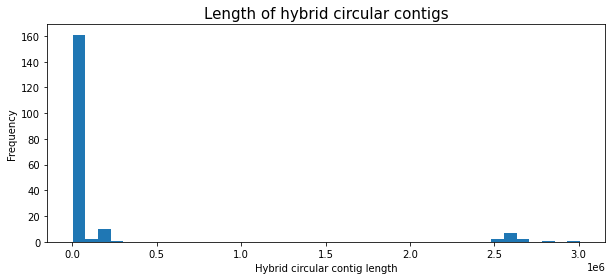

In [ ]:
figure5 = CIRCULAR_CONTIGS.hist(column=["contig_length"], bins=40, figsize=(10,4))
plt.title('Length of hybrid circular contigs', fontsize=15)
plt.xlabel('Hybrid circular contig length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

As with E. faecalis, the choice for L is left unclear. We choose a small value of L = 300000.

In [ ]:
EFAECIUM_THRESHOLD = 300000

In [ ]:
print(f'Over all E. faecium isolates there are {len(CIRCULAR_CONTIGS)} circular contigs')
print(f'  {len(CIRCULAR_CONTIGS_CHROM)} are classified as chromosome')
print(f'  {len(CIRCULAR_CONTIGS_PLASMIDS)} are classified as plasmid')

Over all E. faecium isolates there are 187 circular contigs
  13 are classified as chromosome
  174 are classified as plasmid


E. faecium shows the same trend as E. faecalis. The number of chromosome contigs is very small compared to the total number of isolates indicating that not all chromosomes are not fully assembled. 

##### Hybrid contigs classified as plasmids

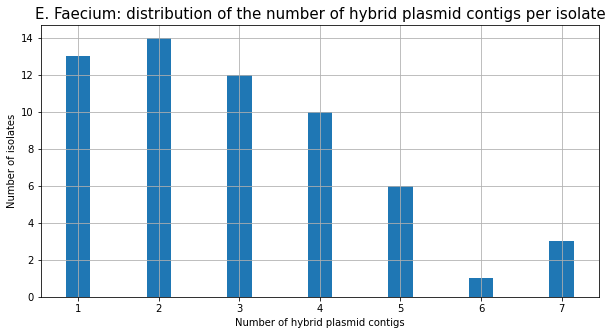

In [ ]:
# Number of hybrid plasmid ontigs per isolate with at least one
EFAECIUM_PLASMIDS_CTGS_labels, EFAECIUM_PLASMIDS_CTGS_counts = np.unique(EFAECIUM_PLASMIDS['SRA'].value_counts(), return_counts=True)
figure6 = plt.figure(figsize=(10,5))
plt.title('E. Faecium: distribution of the number of hybrid plasmid contigs per isolate', fontsize=15)
plt.xlabel('Number of hybrid plasmid contigs')
plt.ylabel('Number of isolates')
plt.bar(EFAECIUM_PLASMIDS_CTGS_labels, EFAECIUM_PLASMIDS_CTGS_counts, align='center', width=0.3)
plt.grid()
plt.gca().set_xticks(EFAECIUM_PLASMIDS_CTGS_labels)
plt.show()

##### Distribution of contig lengths per label

We now look at the three classes of contigs (plasmid, chromsome and ambiguous) for E. faecium isolates.

In [ ]:
#Re-assigning labels to non-circular contigs smaller than the threshold as 'ambiguous'
for i, row in EFAECIUM_CONTIGS.iterrows():
    if (EFAECIUM_CONTIGS.loc[i,'classification'] == 'chromosome') & (EFAECIUM_CONTIGS.loc[i,'contig_length'] <= 300000):
        EFAECIUM_CONTIGS.at[i,'classification'] = 'ambiguous'

In [ ]:
EFAECIUM_PLASMID_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'chromosome'].shape[0]
EFAECIUM_CHROM_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'plasmid'].shape[0]
EFAECIUM_AMBIG_NB = EFAECIUM_CONTIGS[EFAECIUM_CONTIGS['classification'] == 'ambiguous'].shape[0]
print(f'Number of chromosome contigs: {EFAECIUM_CHROM_NB}')
print(f'Number of plasmid contigs: {EFAECIUM_PLASMID_NB}')
print(f'Number of ambiguous contigs: {EFAECIUM_AMBIG_NB}')

Number of chromosome contigs: 174
Number of plasmid contigs: 114
Number of ambiguous contigs: 3250


Hybrid contig length distribution per class


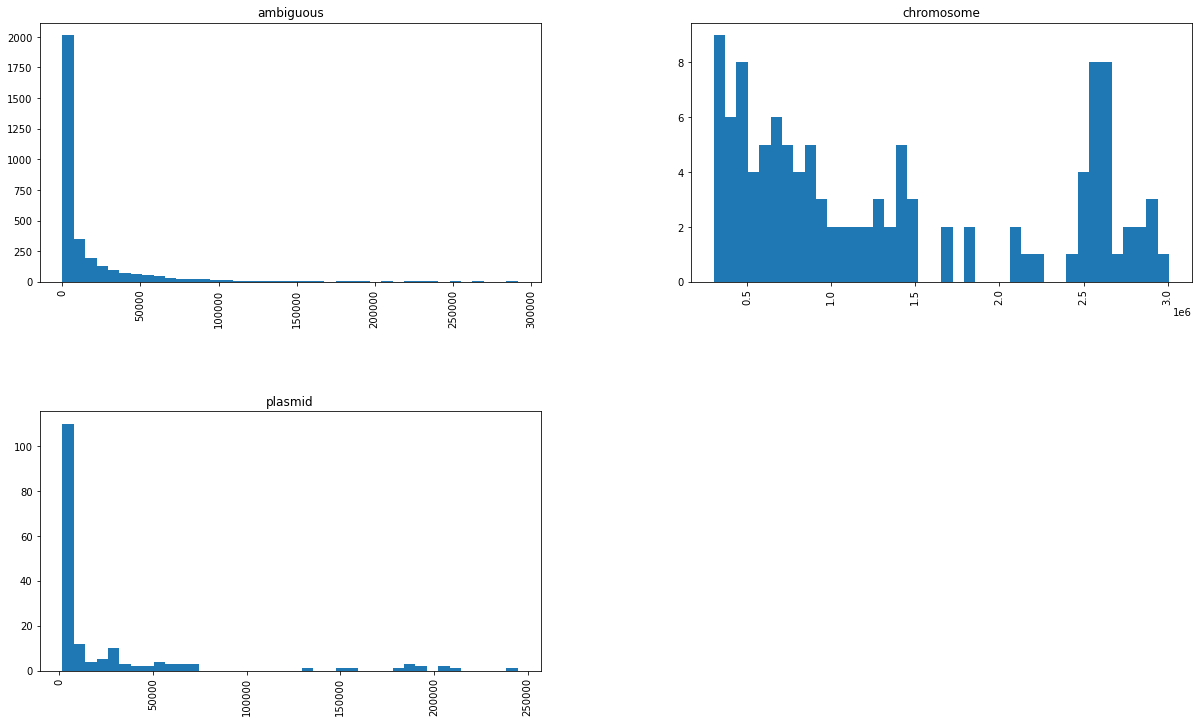

In [ ]:
EFAECIUM_CONTIGS_LEN = EFAECIUM_CONTIGS[['contig_length','classification']]
print(f'Hybrid contig length distribution per class')
figure7 = EFAECIUM_CONTIGS_LEN.hist(by="classification", bins=40, figsize=(20, 12))

In [ ]:
nb_short_contigs = len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= EFAECIUM_THRESHOLD)])
nb_short_ambig_contigs = len(EFAECIUM_CONTIGS[(EFAECIUM_CONTIGS["contig_length"] <= EFAECIUM_THRESHOLD) & (EFAECIUM_CONTIGS['classification'] == 'ambiguous')])
print(f'{nb_short_contigs} out of {EFAECIUM_CONTIGS_NB} contigs are under {EFAECIUM_THRESHOLD} bp in length and {nb_short_ambig_contigs} of these contigs have been classified as ambiguous.')

3424 out of 3538 contigs are under 300000 bp in length and 3250 of these contigs have been classified as ambiguous.


All of the ambiguous and plasmid contigs are shorter than 150000 bp. This indicates a strong separation between ambiguous/plasmid and chromosome contigs, with the chosen threshold (300000bp). However, it is unclear if ambiguous contigs are  fragments of chromosomes or should be considered independent plasmids.

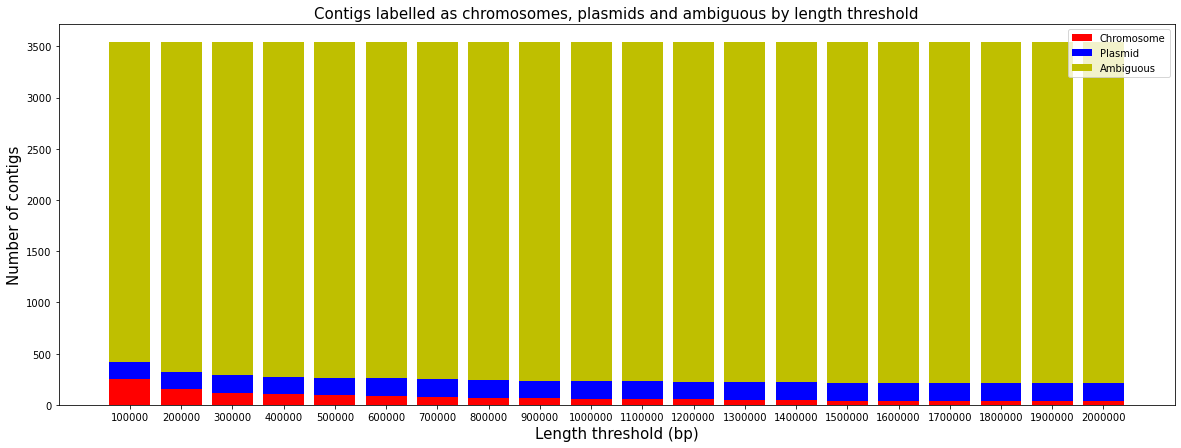

In [ ]:
EFAECIUM_CHR_BY_THRESHOLD, EFAECIUM_PLS_BY_THRESHOLD, EFAECIUM_AMB_BY_THRESHOLD = np.empty(20),np.empty(20),np.empty(20) 

for i in range(len(THRESHOLDS)):
    L = THRESHOLDS[i]
    CHR_NB, PLS_NB, AMB_NB = split_by_threshold(L, EFAECIUM_CONTIGS)
    EFAECIUM_CHR_BY_THRESHOLD[i] = CHR_NB 
    EFAECIUM_PLS_BY_THRESHOLD[i] = PLS_NB
    EFAECIUM_AMB_BY_THRESHOLD[i] = AMB_NB
THR_LIST = [str(x) for x in THRESHOLDS]

figure3 = plt.figure(figsize=(20,7))
plt.bar(THR_LIST, EFAECIUM_CHR_BY_THRESHOLD, color='r')
plt.bar(THR_LIST, EFAECIUM_PLS_BY_THRESHOLD, bottom=EFAECIUM_CHR_BY_THRESHOLD, color='b')
plt.bar(THR_LIST, EFAECIUM_AMB_BY_THRESHOLD, bottom=EFAECIUM_CHR_BY_THRESHOLD+EFAECIUM_PLS_BY_THRESHOLD, color='y')

plt.xlabel("Length threshold (bp)",fontsize=15)
plt.ylabel("Number of contigs",fontsize=15)
plt.legend(["Chromosome", "Plasmid", "Ambiguous"],fontsize=10)
plt.title("Contigs labelled as chromosomes, plasmids and ambiguous by length threshold",fontsize=15)
plt.show()

#### Landscape of contigs distribution

In [ ]:
EFAECIUM_CONTIGS_GROUPED_DICT = {}
for idx, row in EFAECIUM_CONTIGS.iterrows():
    EFAECIUM_CONTIGS_GROUPED_DICT[row['SRA']] = defaultdict(int)
for idx, row in EFAECIUM_CONTIGS.iterrows():
    EFAECIUM_CONTIGS_GROUPED_DICT[row['SRA']][row['classification']] += 1
EFAECIUM_CONTIGS_GROUPED = pd.DataFrame.from_dict(EFAECIUM_CONTIGS_GROUPED_DICT, orient='index').fillna(0)
EFAECIUM_CONTIGS_GROUPED.sort_values('ambiguous', inplace=True, ascending=False)

In [ ]:
print('First 50 E. faecium samples')
EFAECIUM_CONTIGS_GROUPED.head(50)

First 50 E. faecium samples


,chromosome,ambiguous,plasmid
SRR14022764,1.0,237.0,0.0
SRR14010969,0.0,184.0,4.0
SRR14011002,0.0,173.0,4.0
SRR14026515,0.0,170.0,2.0
SRR14010946,0.0,167.0,2.0
SRR14011041,0.0,166.0,3.0
SRR14010961,1.0,148.0,3.0
SRR14022770,0.0,143.0,0.0
SRR14022782,2.0,129.0,1.0
SRR14026532,0.0,128.0,0.0


#### Summary

Overall similar to *E. faecalis* but for a more serious issue with the number of ambiguous contigs, and some cases where the assembly is so fragmented that there are actually no contig labelled as chromosome.

## Comparison against ground truth

We used PlasBin, HyAsP, MOB-recon and plasmidSPAdes to predict plasmids using the short read contigs and assembly graphs. Thus, we obtained plasmids as bins of short read contigs. We use hybrid contigs classified as plasmids to represent the ground truth plasmids. In order to compare the predictions against the ground truth, we obtain short read contig set representations of the hybrid contigs. We do so by mapping the short read contigs onto the hybrid contigs using minimap2. The hybrid contig mappings have been stored in the "data/Hybrid_Contigs_Plasmids". For each isolate, we then compare the predictions against the ground truth plasmid bins using PlasEval. We obtain a score that measures the dissimilarity between the ground truth and the predicted plasmid bins.

In [ ]:
EFAECALIS_ISOLATES = pd.read_csv('isolate_details_Efaecalis.csv')
EFAECIUM_ISOLATES = pd.read_csv('isolate_details_Efaecium.csv')

#### E. faecalis

In [92]:
#EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'][~EFAECALIS_ISOLATES.loc[:, EFAECALIS_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

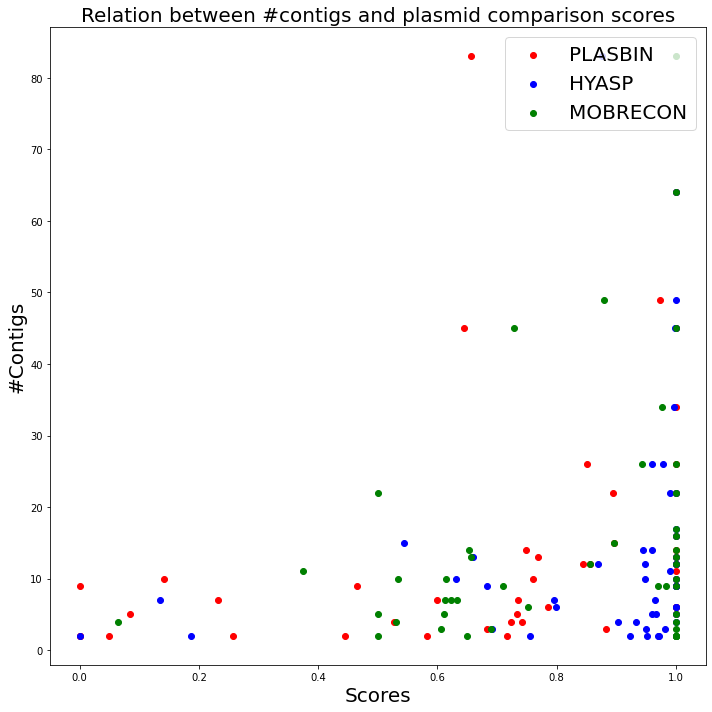

In [96]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECALIS_ISOLATES['pb'],y=EFAECALIS_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECALIS_ISOLATES['hy'],y=EFAECALIS_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECALIS_ISOLATES['mob'],y=EFAECALIS_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. This suggests that the ground truth is dissimilar to the predicted plasmid bins. Furthermore, if the isolate contains more than 20 hybrid contigs, the dissimilarity score is almost always above 0.5. There is no clear indication as to which tool performs better in terms of similarity to the ground truth.

#### E. faecium

In [94]:
#EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'][~EFAECIUM_ISOLATES.loc[:, EFAECIUM_ISOLATES.columns != 'psp'].isnull().any(axis=1)]

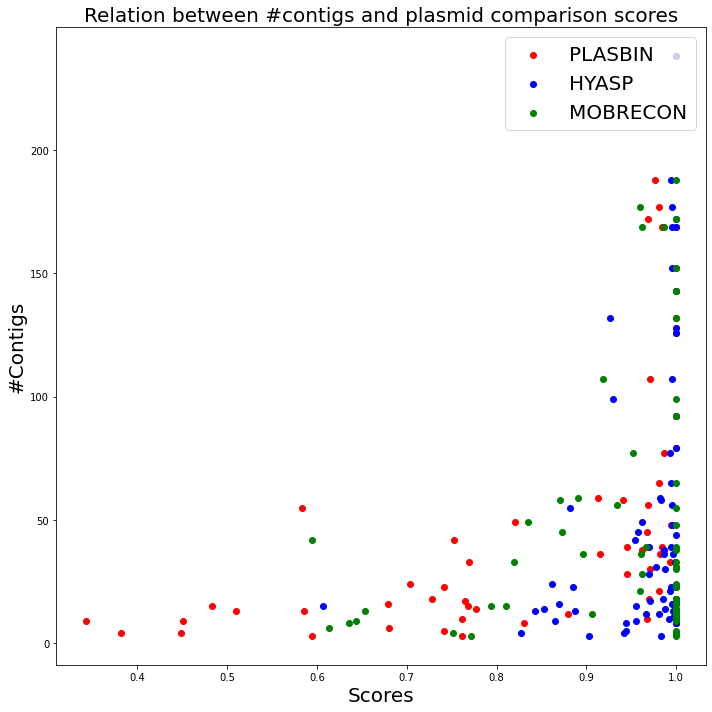

In [95]:
plt.title('Relation between #contigs and plasmid comparison scores',fontsize=20)
plt.xlabel('Scores',fontsize=20)
plt.ylabel('#Contigs',fontsize=20)

plt.scatter(x=EFAECIUM_ISOLATES['pb'],y=EFAECIUM_ISOLATES['nb_ctg'],color='red',label='PLASBIN')
plt.scatter(x=EFAECIUM_ISOLATES['hy'],y=EFAECIUM_ISOLATES['nb_ctg'],color='blue',label='HYASP')
plt.scatter(x=EFAECIUM_ISOLATES['mob'],y=EFAECIUM_ISOLATES['nb_ctg'],color='green',label='MOBRECON')
#plt.scatter(x=EFAECALIS_ISOLATES['psp'],y=EFAECALIS_ISOLATES['nb_ctg'],color='black',label='PSPADES')

plt.legend(loc='upper right',fontsize=20)
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
 
plt.show()

From this plot, we can see very few scores below 0.5. In fact, all tools consistently have predictions that have a dissimilarity score >= 0.5, with the exception of PlasBin. For isolates having more than 50 contigs, the dissimilarity score is almost always greater than 0.6. 

The high level of dissimilarity from all the tools can be explained by the lack of representation of plasmidic hybrid contigs in the dataset. It is likely that the plasmids have been fragemented into smaller linear contigs. As a result, these contigs are misclassified. This can be especially observed in isolates with high number of contigs.